In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import tqdm

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
merged_files_filtered = pd.read_csv("./data/dataset_with_diseases.csv")

In [8]:
new_text = """
THE PATIENT'S ATTORNEY ALLEGED A DEFICIENCY AGAINST THE DEVICE RESULTING IN AN UNSPECIFIED ADVERSE OUTCOME. PRODUCT WAS USED FOR THERAPEUTIC TREATMENT. THE PREOPERATIVE DIAGNOSIS WAS STRESS URINARY INCONTINENCE, URINARY URGENCY, OVERACTIVE BLADDER, AND URETHROCELE. THE POSTOPERATIVE DIAGNOSIS WAS STRESS URINARY INCONTINENCE, URINARY URGENCY, OVERACTIVE BLADDER, AND URETHROCELE, BLADDER LESION, AND INTERSTITIAL CYSTITIS. THE PROCEDURE PERFORMED WAS A URETHROCELE REPAIR, CYSTOURETHROSCOPY WITH BLADDER BIOPSY, AND A TRANSOBTURATOR TAPE SLING. THE PATIENT RETURNED FOR AN OFFICE VISIT ON (B)(6) 2005 FOR A D/C CATH. THE PATIENT COMPLAINED OF PAIN IN THE TOP OF THE RIGHT LEG. THE PATIENT RETURNED FOR AN OFFICE VISIT ON (B)(6) 2005 FOR BLOOD IN THE URINE. THE PATIENT COMPLAINS OF BLEEDING,CRAMPS, AND THROBBING PAIN. THE PATIENT RETURNED FOR AN OFFICE VISIT ON (B)(6) 2005 FOR PAINFUL INTERCOURSE AND HOT FLASHES AT NIGHT. THE PATIENT RETURNED FOR AN OFFICE VISIT ON (B)(6) 2005 FOR FOLLOW UP FOR YEAST INFECTION. THE PATIENT UNDERWENT AN ADDITIONAL PROCEDURE ON (B)(6) 2008. THE PREOPERATIVE DIAGNOSIS AND POSTOPERATIVE DIAGNOSIS WAS PAINFUL VAGINAL SCAR BAND THAT WAS CAUSING DISCOMFORT FOR HER DURING INTERCOURSE AND PAIN TO HER HUSBAND. THE NAME OF THE PROCEDURE PERFORMED WAS EXCISION OF IRREGULAR VAGINAL SCAR AND EXCISION OF PORTION OF MESH. A PHONE CALL WAS MADE ON (B)(6) 2008 FOR ITCHING/YEAST. THE PATIENT UNDERWENT AN ADDITIONAL PROCEDURE ON (B)(6) 2013. THE PREOPERATIVE AND POSTOPERATIVE DIAGNOSIS WAS A 2.5 MM DISTAL LEFT URETERAL STONE, A 1X2 MM MID LEFT KIDNEY STONE. THE PROCEDURE PERFORMED WAS A RIGID AND FLEXIBLE URETEROSCOPIC STONE EXTRACTION.
""".lower()

In [5]:
import spacy
from spacy import displacy

In [7]:
nlp = spacy.load("en_ner_bc5cdr_md")
doc = nlp(new_text)
displacy.render(doc, style="ent", jupyter=True)

In [9]:
text_lst = []
i = 0

for text in merged_files_filtered['FOI_TEXT']:

    doc = nlp(text.lower())
    entities = [ent.text for ent in doc.ents if ent.label_ == 'DISEASE']
    if entities != []:
        text_lst.append(entities)
    
text_lst[0]

['adenomyosis',
 'uterovaginal prolapse',
 'stress urinary incontinence',
 'cystocele',
 'erosion of vaginal mesh and lesion']

In [10]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(text_lst)

# id2word.filter_extremes(no_below=5, no_above=0.5)

# Create Corpus
texts = text_lst

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]


In [9]:
import gensim
# Build LDA model
lda_model = gensim.models.LdaMulticore(
    corpus=corpus,
    id2word=id2word,
    num_topics=5,
    random_state=100,
    chunksize=100,
    passes=10,
    per_word_topics=True,
)

In [10]:
from pprint import pprint

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.447*"incontinence" + 0.017*"hematuria" + 0.017*"interstitial cystitis" + '
  '0.011*"pyelonephritis" + 0.009*"trauma" + 0.009*"bladder outlet '
  'obstruction" + 0.009*"stenosis" + 0.009*"urinary tract infections" + '
  '0.009*"unspecified injury" + 0.008*"diabetes"'),
 (1,
  '0.161*"pain" + 0.041*"urinary incontinence" + 0.036*"pelvic pain" + '
  '0.026*"tenderness" + 0.024*"dyspareunia" + 0.020*"dysuria" + 0.019*"stress '
  'incontinence" + 0.018*"stress urinary incontinence" + 0.017*"abdominal '
  'pain" + 0.017*"constipation"'),
 (2,
  '0.479*"pain" + 0.102*"pelvic pain" + 0.068*"vaginal pain" + 0.060*"groin '
  'pain" + 0.026*"anal pain" + 0.017*"psychiatric" + 0.012*"incontinence" + '
  '0.011*"aggrav" + 0.011*"perineum pain" + 0.011*"nerve pain"'),
 (3,
  '0.169*"pain" + 0.069*"dyspareunia" + 0.034*"inflammation" + '
  '0.034*"infection" + 0.029*"pelvic pain" + 0.027*"abdominal pain" + '
  '0.023*"urinary retention" + 0.023*"dysuria" + 0.020*"infections" + '
  '0.018*"

In [11]:
from gensim.models import CoherenceModel
# Building LDA model with varying number of topics
min_topics = 2
max_topics = 8
step_size = 1
random_state = 42

coherence_scores = []
lda_model_collection = []
coherence_model_collection = []

for num_topics in range(min_topics, max_topics + step_size, step_size):
    lda_model_collection.append(
        gensim.models.LdaModel(
            corpus,
            num_topics=num_topics,
            random_state=random_state,
            id2word=id2word,
            passes=10,
        )
    )

    coherence_model_collection.append(
        CoherenceModel(
            model=lda_model_collection[num_topics - 2],
            texts=text_lst,
            dictionary=id2word,
            coherence="c_v",
        )
    )

    coherence_scores.append(coherence_model_collection[num_topics - 2].get_coherence())

    print(
        f"Number of topics: {num_topics}, Coherence Score: {coherence_scores[num_topics-2]}"
    )

# Creating DataFrame of number of topics and corresponding coherence score
coherence_scores_df = pd.DataFrame(
    {
        "num_topics": range(min_topics, max_topics + step_size, step_size),
        "coherence_score": coherence_scores,
    }
)

Number of topics: 2, Coherence Score: 0.5280502821681377
Number of topics: 3, Coherence Score: 0.5315687392218772
Number of topics: 4, Coherence Score: 0.5180064870989756
Number of topics: 5, Coherence Score: 0.48059095339022784
Number of topics: 6, Coherence Score: 0.4853390791278109
Number of topics: 7, Coherence Score: 0.4686852980066781
Number of topics: 8, Coherence Score: 0.46985656028725425


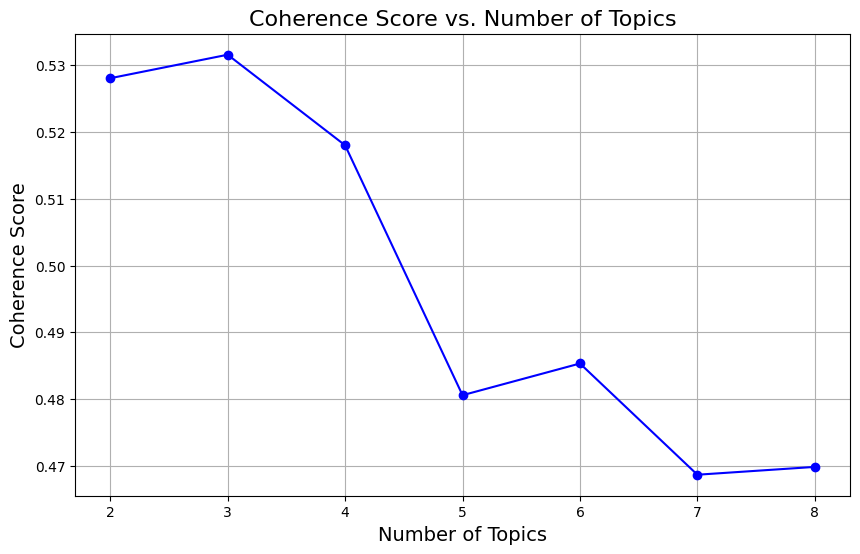

In [12]:
import matplotlib.pyplot as plt

# Create a line plot
plt.figure(figsize=(10, 6))
plt.plot(
    coherence_scores_df['num_topics'],
    coherence_scores_df['coherence_score'],
    marker='o',  # Add markers for better visibility
    linestyle='-',  # Line style
    color='b'  # Line color
)

# Add titles and labels
plt.title('Coherence Score vs. Number of Topics', fontsize=16)
plt.xlabel('Number of Topics', fontsize=14)
plt.ylabel('Coherence Score', fontsize=14)
plt.xticks(coherence_scores_df['num_topics'])  # Set x-ticks to the number of topics
plt.grid()  # Add a grid for better readability

# Show the plot
plt.show()


In [16]:
list(np.arange(0.01, 1, 0.1))

[0.01,
 0.11,
 0.21000000000000002,
 0.31000000000000005,
 0.41000000000000003,
 0.51,
 0.6100000000000001,
 0.7100000000000001,
 0.81,
 0.91]

In [23]:
selected_num_topics = 3

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.1))
alpha.append("symmetric")
alpha.append("asymmetric")

# Beta parameter
beta = list(np.arange(0.01, 1, 0.1))
beta.append("symmetric")

hyper_parameter_tuning_lda_model_collection = []
hyper_parameter_tuning_coherence_model_collection = []
hyper_parameter_tuning_coherence_scores = []

hyper_parameter_tuning_results = {
    "num_topics": [],
    "alpha": [],
    "beta": [],
    "coherence_score": [],
}

# iterate through alpha values
for index, a in enumerate(alpha):
    # iterare through beta values
    for b in beta:
        hyper_parameter_tuning_lda_model_collection.append(
            gensim.models.LdaModel(
                corpus,
                num_topics=selected_num_topics,
                alpha=a,
                eta=b,
                random_state=random_state,
                id2word=id2word,
                passes=10,
            )
        )

        hyper_parameter_tuning_coherence_model_collection.append(
            CoherenceModel(
                model=hyper_parameter_tuning_lda_model_collection[-1],
                texts=text_lst,
                dictionary=id2word,
                coherence="c_v",
            )
        )

        hyper_parameter_tuning_coherence_scores.append(
            hyper_parameter_tuning_coherence_model_collection[-1].get_coherence()
        )

        # Save the model results
        hyper_parameter_tuning_results["num_topics"].append(selected_num_topics)
        hyper_parameter_tuning_results["alpha"].append(a)
        hyper_parameter_tuning_results["beta"].append(b)
        hyper_parameter_tuning_results["coherence_score"].append(
            hyper_parameter_tuning_coherence_scores[-1]
        )

        print(
            f"Num_Topics: {selected_num_topics}, Alpha: {a}, Beta: {b}, Coherence_Score: {hyper_parameter_tuning_coherence_scores[-1]}"
        )

hyper_parameter_tuning_results_df = pd.DataFrame(hyper_parameter_tuning_results)

Num_Topics: 3, Alpha: 0.01, Beta: 0.01, Coherence_Score: 0.5239644075160955
Num_Topics: 3, Alpha: 0.01, Beta: 0.11, Coherence_Score: 0.5051648931479896
Num_Topics: 3, Alpha: 0.01, Beta: 0.21000000000000002, Coherence_Score: 0.5228742899940803
Num_Topics: 3, Alpha: 0.01, Beta: 0.31000000000000005, Coherence_Score: 0.5223227190620227
Num_Topics: 3, Alpha: 0.01, Beta: 0.41000000000000003, Coherence_Score: 0.5182296816727557
Num_Topics: 3, Alpha: 0.01, Beta: 0.51, Coherence_Score: 0.5029948516419819
Num_Topics: 3, Alpha: 0.01, Beta: 0.6100000000000001, Coherence_Score: 0.4847095007658318
Num_Topics: 3, Alpha: 0.01, Beta: 0.7100000000000001, Coherence_Score: 0.5046142426589363
Num_Topics: 3, Alpha: 0.01, Beta: 0.81, Coherence_Score: 0.47031255447667536
Num_Topics: 3, Alpha: 0.01, Beta: 0.91, Coherence_Score: 0.4625839020165135
Num_Topics: 3, Alpha: 0.01, Beta: symmetric, Coherence_Score: 0.5228742899940803
Num_Topics: 3, Alpha: 0.11, Beta: 0.01, Coherence_Score: 0.5437805636728279
Num_Topic

In [24]:
hyper_parameter_tuning_results_df

,num_topics,alpha,beta,coherence_score
0,3,0.01,0.01,0.523964
1,3,0.01,0.11,0.505165
2,3,0.01,0.21,0.522874
3,3,0.01,0.31,0.522323
4,3,0.01,0.41,0.518230
...,...,...,...,...
127,3,asymmetric,0.61,0.557303
128,3,asymmetric,0.71,0.564677
129,3,asymmetric,0.81,0.558535
130,3,asymmetric,0.91,0.577395


In [25]:
hyper_parameter_tuning_max_score_index = hyper_parameter_tuning_results_df[
    "coherence_score"
].idxmax()
print(hyper_parameter_tuning_max_score_index)

130


In [ ]:
from gensim.models import CoherenceModel

# Compute Coherence Score
# TODO: Pickle these as the baseline models
coherence_model_lda = CoherenceModel(
    model=lda_model, texts=text_lst, dictionary=id2word, coherence="c_v"
)
coherence_lda = coherence_model_lda.get_coherence()
print("Coherence Score: ", coherence_lda)

In [26]:
# 3	symmetric	0.01	0.611806
# 3 asymmetric 0.91
# 3	asymmetric	0.31	0.646348

num_topics = 3
alpha = 'asymmetric'
beta = 0.91

# num_topics = 2
# alpha = 0.01
# beta = 0.01

lda_model = gensim.models.LdaMulticore(
    corpus=corpus,
    id2word=id2word,
    num_topics=num_topics,
    random_state=42,
    chunksize=100,
    passes=10,
    alpha=alpha,
    eta=beta,
)

In [27]:
import pickle
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)

LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.225120  0.028085       1        1  52.629719
0     -0.078781 -0.154418       2        1  33.817025
2     -0.146339  0.126334       3        1  13.553257, topic_info=                            Term          Freq         Total Category  \
10                          pain  10635.000000  10635.000000  Default   
3    stress urinary incontinence   1013.000000   1013.000000  Default   
58                   dyspareunia    961.000000    961.000000  Default   
179                 vaginal pain   1123.000000   1123.000000  Default   
353                   groin pain    901.000000    901.000000  Default   
..                           ...           ...           ...      ...   
10                          pain     73.655214  10635.221229   Topic3   
463                     numbness     32.210198    232.133666   Topic3   
140                 constipation     32.380182    272.001959   Topic3   
53      urinary tract infections     28.720784    205.378250   Topic3   
212                   tenderness     29.360991    365.429928   Topic3   

     logprob  loglift  
10   30.0000  30.0000  
3    29.0000  29.0000  
58   28.0000  28.0000  
179  27.0000  27.0000  
353  26.0000  26.0000  
..       ...      ...  
10   -4.5533  -2.9740  
463  -5.3804   0.0235  
140  -5.3751  -0.1297  
53   -5.4950   0.0313  
212  -5.4730  -0.5229  

[191 rows x 6 columns], token_table=      Topic      Freq                  Term
term                                       
36        1  0.315520        abdominal pain
36        2  0.454662        abdominal pain
36        3  0.231251        abdominal pain
1556      1  0.051698  abnormal muscle tone
1556      2  0.051698  abnormal muscle tone
...     ...       ...                   ...
299       2  0.018955              vomiting
299       3  0.701326              vomiting
846       1  0.896060              weakness
846       2  0.040730              weakness
846       3  0.081460              weakness

[414 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3])

In [27]:
stop_words = set(stopwords.words('english'))

Topic 1:


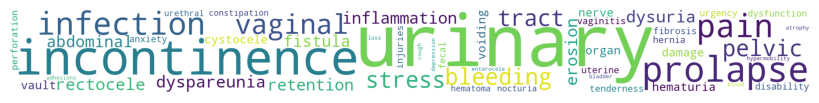

------------------------------
Topic 2:


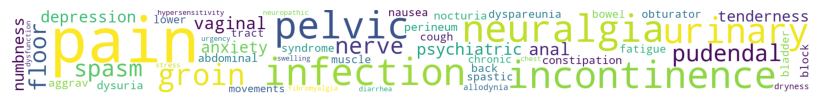

------------------------------
Topic 3:


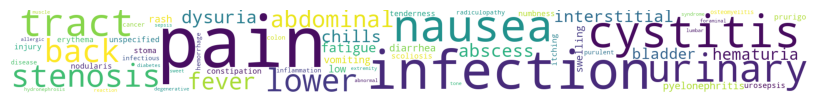

------------------------------


In [36]:
from wordcloud import WordCloud

color_map = 'viridis'
topics = lda_model.show_topics(num_topics=3, num_words=50)
for topic in topics:
    print(f"Topic {topic[0]+1}:")
    wordcloud = WordCloud(
        width=1920, background_color="white", stopwords=stop_words, min_font_size=10,colormap=color_map 
    ).generate(topic[1])
    plt.figure(figsize=(8, 8), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()
    print("-" * 30)

In [37]:
from pprint import pprint

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.060*"incontinence" + 0.056*"stress urinary incontinence" + '
  '0.049*"dyspareunia" + 0.034*"urinary incontinence" + 0.027*"stress '
  'incontinence" + 0.025*"bleeding" + 0.020*"rectocele" + 0.019*"pelvic pain" '
  '+ 0.017*"dysuria" + 0.016*"inflammation"'),
 (1,
  '0.382*"pain" + 0.074*"pelvic pain" + 0.050*"incontinence" + 0.041*"vaginal '
  'pain" + 0.033*"groin pain" + 0.014*"anal pain" + 0.010*"psychiatric" + '
  '0.010*"depression" + 0.010*"anxiety" + 0.009*"pudendal neuralgia"'),
 (2,
  '0.020*"infection" + 0.017*"abdominal pain" + 0.015*"fever" + '
  '0.015*"dysuria" + 0.013*"abscess" + 0.012*"interstitial cystitis" + '
  '0.011*"pain" + 0.010*"chills" + 0.009*"hematuria" + 0.009*"nausea"')]


In [11]:
from gensim.models.nmf import Nmf

In [13]:
# Topics range
min_topics = 1
max_topics = 10
step = 1

# The number of top words per topic
num_top_words = 30

# Initial random state
random_state = 42

In [16]:
# import pandas as pd
# import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
# from gensim import corpora
from gensim.models import CoherenceModel
# from gensim.models.nmf import Nmf

import warnings
warnings.filterwarnings("ignore")

# Converting the preprocessed sentences to a list
# processed_sentences = merged_files_filtered["disease_tokens"]


# Creating a TfidfVectorizer object
# vectorizer = TfidfVectorizer(stop_words="english")
# vectorized_sentences = vectorizer.fit_transform(processed_sentences)

# Splitting each sentence into a list of words for Gensim
# texts = text_lst
# processed_sentences.apply(lambda x: nltk.word_tokenize(x)).tolist()

# Creating a dictionary from the words
dictionary = corpora.Dictionary(texts)

# Creating a bag-of-words representation of the corpus
# corpus = [dictionary.doc2bow(text) for text in texts]

# Creating an empty dataframe to hold the NMF weights
nmf_weights_df = pd.DataFrame()

# To store coherence scores and models
coherence_scores = []
nmf_model_collection = []
nmf_result_collection = []
coherence_model_collection = []

# Running NMF for different values of k (number of topics)
for k in range(step, max_topics + 1, step):
    # Fit NMF model using Gensim's Nmf
    nmf_model = Nmf(corpus=corpus, num_topics=k, id2word=id2word, random_state=random_state)
    
    nmf_model_collection.append(nmf_model)

    # Get the topics as list of top words
    topics = nmf_model.show_topics(num_topics=k, num_words=num_top_words, formatted=False)

    # Extract top words for each topic
    topics_words = [[word for word, weight in topic_words] for _, topic_words in topics]

    # Add the NMF weights to the dataframe (optional, for tracking purposes)
    nmf_weights = pd.DataFrame([dict(topic_words) for _, topic_words in topics]).add_prefix("Topic_")
    nmf_weights["k"] = k
    nmf_weights_df = pd.concat([nmf_weights_df, nmf_weights])

    # Normalize the weights so they sum to 1
    nmf_weights_df.iloc[:, :-1] = nmf_weights_df.iloc[:, :-1].div(nmf_weights_df.iloc[:, :-1].sum(axis=1), axis=0)

    # Compute Coherence Score using Gensim's CoherenceModel
    coherence_model = CoherenceModel(
        model=nmf_model, texts=texts, dictionary=dictionary, coherence="c_v"
    )
    coherence_model_collection.append(coherence_model)

    # Append the coherence score
    coherence_scores.append(coherence_model.get_coherence())

    print(f"Number of topics: {k}, Coherence Score: {coherence_scores[-1]}")

# Creating a DataFrame for coherence scores for each number of topics (k)
coherence_scores_df = pd.DataFrame(
    {"k": range(min_topics, max_topics + 1), "coherence_score": coherence_scores}
)

# Print the resulting coherence scores dataframe
print(coherence_scores_df)


Number of topics: 1, Coherence Score: 0.6665615993604576
Number of topics: 2, Coherence Score: 0.6776711452606552
Number of topics: 3, Coherence Score: 0.5563676223745052
Number of topics: 4, Coherence Score: 0.5595855933356695
Number of topics: 5, Coherence Score: 0.5759927306120394
Number of topics: 6, Coherence Score: 0.5574275513672897
Number of topics: 7, Coherence Score: 0.5869518560158519
Number of topics: 8, Coherence Score: 0.5348470283734656
Number of topics: 9, Coherence Score: 0.5561030548034358
Number of topics: 10, Coherence Score: 0.5333665536986179
    k  coherence_score
0   1         0.666562
1   2         0.677671
2   3         0.556368
3   4         0.559586
4   5         0.575993
5   6         0.557428
6   7         0.586952
7   8         0.534847
8   9         0.556103
9  10         0.533367


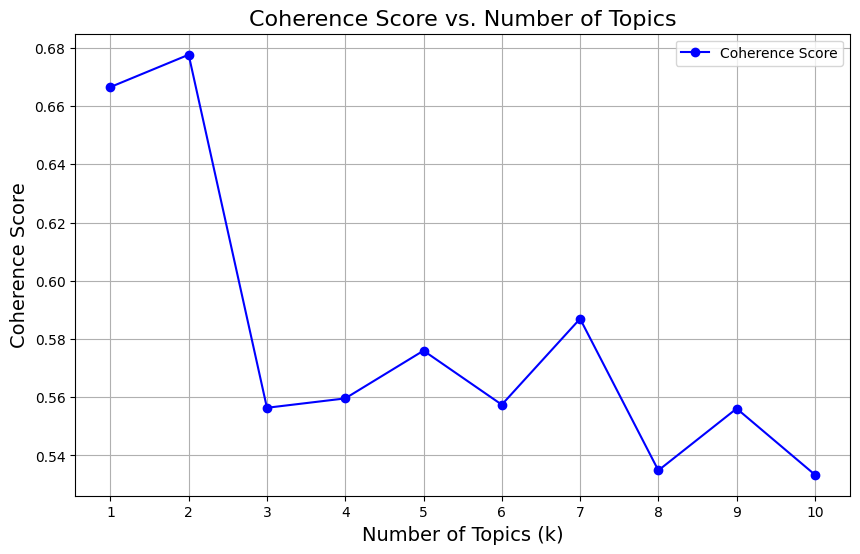

In [17]:
import matplotlib.pyplot as plt

# Plotting the line chart
plt.figure(figsize=(10, 6))
plt.plot(
    coherence_scores_df['k'],  # Number of topics on the x-axis
    coherence_scores_df['coherence_score'],  # Coherence score on the y-axis
    marker='o',  # Markers for each point
    linestyle='-',  # Solid line
    color='b',  # Line color
    label='Coherence Score'
)

# Adding title and labels
plt.title('Coherence Score vs. Number of Topics', fontsize=16)
plt.xlabel('Number of Topics (k)', fontsize=14)
plt.ylabel('Coherence Score', fontsize=14)
plt.xticks(coherence_scores_df['k'])  # Setting x-ticks to show the number of topics
plt.grid(True)  # Adding grid lines for better readability
plt.legend()  # Showing the legend

# Display the plot
plt.show()

In [20]:
best_num_topics = 2

In [22]:
from gensim.models.nmf import Nmf
from gensim.models import CoherenceModel
import pandas as pd

# Define hyperparameter search space
passes = [1, 5, 10]
w_max_iters = [100, 200, 300]
h_max_iters = [50, 100]
kappas = [0.5, 1.0]
minimum_probs = [0.01, 0.05]

best_coherence_score = 0
best_model = None
best_params = {}

# Store results
nmf_hyperparameter_results = []

for p in passes:
    for w_iter in w_max_iters:
        for h_iter in h_max_iters:
            for kappa in kappas:
                for min_prob in minimum_probs:
                    # Train NMF model with hyperparameters
                    nmf_model = Nmf(
                        corpus=corpus,
                        num_topics=best_num_topics,  # Use the best number of topics you found earlier
                        id2word=dictionary,
                        passes=p,
                        w_max_iter=w_iter,
                        h_max_iter=h_iter,
                        kappa=kappa,
                        minimum_probability=min_prob,
                        random_state=random_state
                    )

                    # Calculate coherence score
                    coherence_model = CoherenceModel(
                        model=nmf_model,
                        texts=texts,
                        dictionary=dictionary,
                        coherence="c_v"
                    )
                    coherence_score = coherence_model.get_coherence()

                    # Save results
                    nmf_hyperparameter_results.append({
                        'passes': p,
                        'w_max_iter': w_iter,
                        'h_max_iter': h_iter,
                        'kappa': kappa,
                        'minimum_probability': min_prob,
                        'coherence_score': coherence_score
                    })

                    # Track the best model
                    if coherence_score > best_coherence_score:
                        best_coherence_score = coherence_score
                        best_model = nmf_model
                        best_params = {
                            'passes': p,
                            'w_max_iter': w_iter,
                            'h_max_iter': h_iter,
                            'kappa': kappa,
                            'minimum_probability': min_prob
                        }

                    print(f"Passes: {p}, W Max Iter: {w_iter}, H Max Iter: {h_iter}, Kappa: {kappa}, Min Prob: {min_prob}, Coherence: {coherence_score}")

# Create a DataFrame to store all hyperparameter tuning results
nmf_hyperparameter_results_df = pd.DataFrame(nmf_hyperparameter_results)

# Print the best hyperparameters and coherence score
print("Best Hyperparameters:", best_params)
print("Best Coherence Score:", best_coherence_score)

# Print the hyperparameter tuning results
print(nmf_hyperparameter_results_df)


Passes: 1, W Max Iter: 100, H Max Iter: 50, Kappa: 0.5, Min Prob: 0.01, Coherence: 0.6578902257048673
Passes: 1, W Max Iter: 100, H Max Iter: 50, Kappa: 0.5, Min Prob: 0.05, Coherence: 0.6578902257048673
Passes: 1, W Max Iter: 100, H Max Iter: 50, Kappa: 1.0, Min Prob: 0.01, Coherence: 0.6776711452606552
Passes: 1, W Max Iter: 100, H Max Iter: 50, Kappa: 1.0, Min Prob: 0.05, Coherence: 0.6776711452606552
Passes: 1, W Max Iter: 100, H Max Iter: 100, Kappa: 0.5, Min Prob: 0.01, Coherence: 0.6578902257048673
Passes: 1, W Max Iter: 100, H Max Iter: 100, Kappa: 0.5, Min Prob: 0.05, Coherence: 0.6578902257048673
Passes: 1, W Max Iter: 100, H Max Iter: 100, Kappa: 1.0, Min Prob: 0.01, Coherence: 0.6776711452606552
Passes: 1, W Max Iter: 100, H Max Iter: 100, Kappa: 1.0, Min Prob: 0.05, Coherence: 0.6776711452606552
Passes: 1, W Max Iter: 200, H Max Iter: 50, Kappa: 0.5, Min Prob: 0.01, Coherence: 0.6578902257048673
Passes: 1, W Max Iter: 200, H Max Iter: 50, Kappa: 0.5, Min Prob: 0.05, Cohere

In [23]:
# Assuming 'best_params' contains the optimal hyperparameters after tuning

# Extracting the best parameters
best_passes = best_params['passes']
best_w_max_iter = best_params['w_max_iter']
best_h_max_iter = best_params['h_max_iter']
best_kappa = best_params['kappa']
best_min_prob = best_params['minimum_probability']

# Training the final NMF model using the best parameters
final_nmf_model = Nmf(
    corpus=corpus,
    num_topics=best_num_topics,  # Use the optimal number of topics found earlier
    id2word=dictionary,
    passes=best_passes,
    w_max_iter=best_w_max_iter,
    h_max_iter=best_h_max_iter,
    kappa=best_kappa,
    minimum_probability=best_min_prob,
    random_state=random_state
)

# Once trained, you can save the model for future use or analysis
final_nmf_model.save("best_nmf_model.gensim")

# To print topics for inspection
topics = final_nmf_model.show_topics(num_topics=best_num_topics, num_words=10)
for topic in topics:
    print(f"Topic {topic[0]+1}: {topic[1]}")


Topic 1: 0.357*"pain" + 0.055*"pelvic pain" + 0.016*"abdominal pain" + 0.013*"dysuria" + 0.011*"tenderness" + 0.011*"dyspareunia" + 0.010*"anxiety" + 0.010*"constipation" + 0.009*"numbness" + 0.009*"pudendal neuralgia"
Topic 2: 0.086*"incontinence" + 0.047*"pelvic pain" + 0.037*"pain" + 0.033*"stress urinary incontinence" + 0.032*"urinary incontinence" + 0.025*"dyspareunia" + 0.022*"vaginal pain" + 0.019*"stress incontinence" + 0.017*"bleeding" + 0.015*"tenderness"


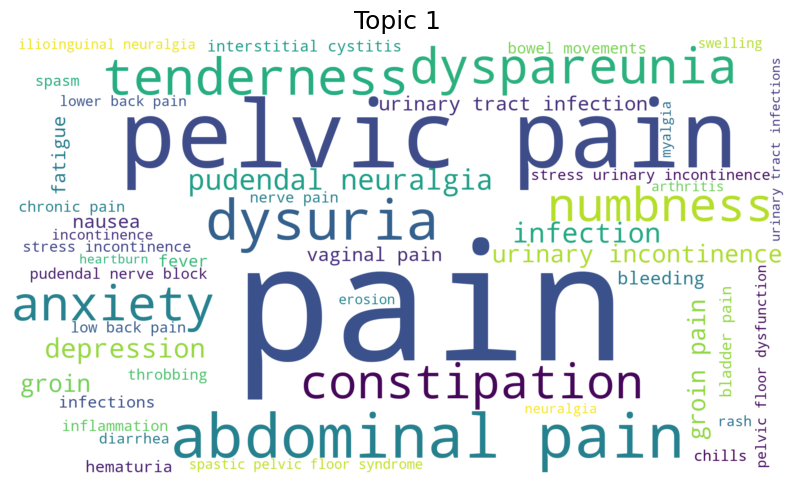

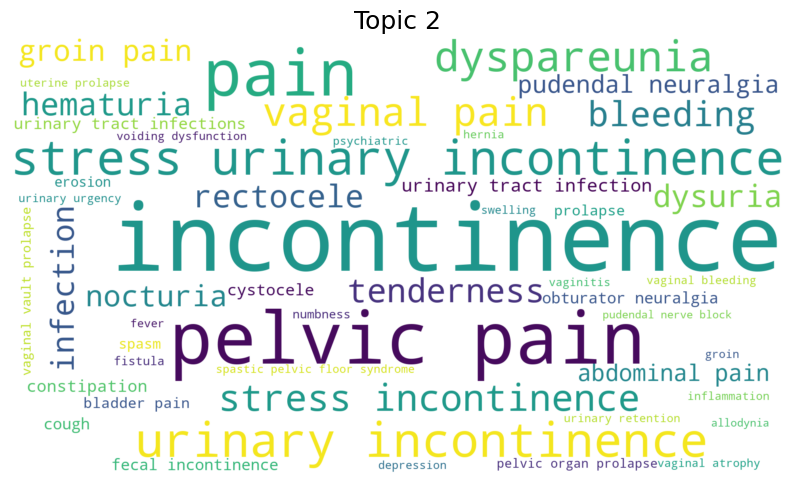

In [24]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Assuming 'final_nmf_model' is the trained NMF model
# Set the number of words to display in the word cloud
num_words = 50  # Change this number as per your preference

# Get the topics from the final NMF model
topics = final_nmf_model.show_topics(num_topics=best_num_topics, num_words=num_words, formatted=False)

# Iterate through the topics and generate word clouds
for topic_index, topic in topics:
    # Extract the words and their corresponding weights
    words_dict = dict(topic)  # Convert list of tuples to a dictionary for WordCloud
    
    # Generate the word cloud
    wordcloud = WordCloud(
        width=1920,
        height=1080,
        background_color='white',
        max_words=num_words,
        colormap='viridis',  # You can change the colormap (e.g., 'plasma', 'inferno')
    ).generate_from_frequencies(words_dict)
    
    # Plot the word cloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Topic {topic_index + 1}", fontsize=18)
    plt.axis("off")
    plt.show()


Topic 1:


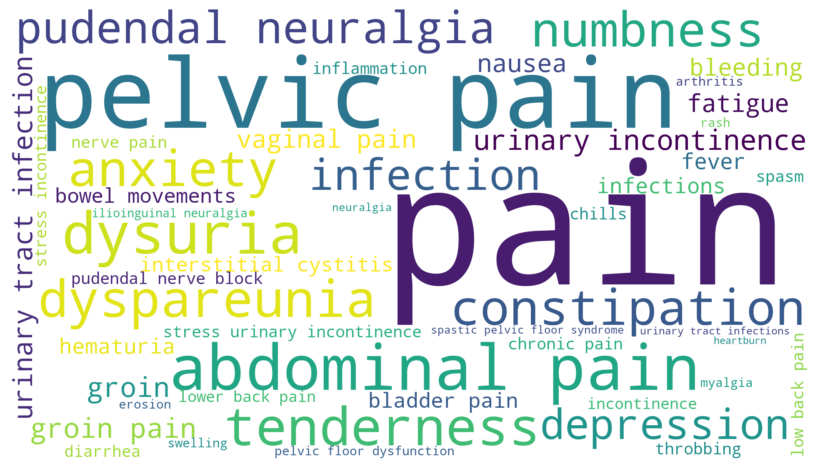

------------------------------
Topic 2:


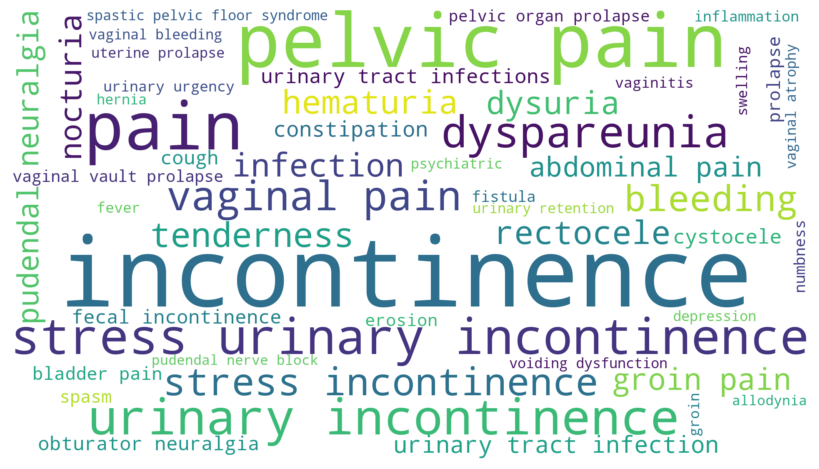

------------------------------


In [28]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

color_map = 'viridis'  # You can change this colormap if you like

# Assuming 'final_nmf_model' is your trained NMF model
# Get the topics from the NMF model
topics = final_nmf_model.show_topics(num_topics=best_num_topics, num_words=50, formatted=False)

# Iterate through the topics and generate word clouds
for topic in topics:
    topic_num = topic[0]  # Topic number
    words = dict(topic[1])  # Convert list of tuples (word, weight) to a dictionary

    print(f"Topic {topic_num + 1}:")
    
    # Generate word cloud
    wordcloud = WordCloud(
        width=1920,
        height=1080,
        background_color="white",
        stopwords=stop_words,  # Ensure stop words are defined earlier in your code
        min_font_size=10,
        colormap=color_map
    ).generate_from_frequencies(words)
    
    # Plot the word cloud
    plt.figure(figsize=(8, 8), facecolor=None)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()
    print("-" * 30)


Topic 1:


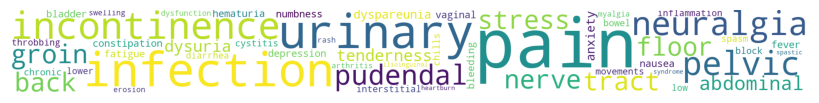

------------------------------
Topic 2:


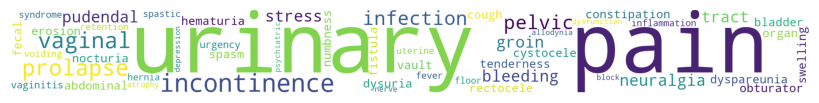

------------------------------


In [29]:

color_map = 'viridis'
topics = final_nmf_model.show_topics(num_topics=2, num_words=50)
for topic in topics:
    print(f"Topic {topic[0]+1}:")
    wordcloud = WordCloud(
        width=1920, background_color="white", stopwords=stop_words, min_font_size=10,colormap=color_map 
    ).generate(topic[1])
    plt.figure(figsize=(8, 8), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()
    print("-" * 30)

In [31]:
from pprint import pprint

# Print the Keyword in the 10 topics
pprint(final_nmf_model.print_topics())

[(0,
  '0.357*"pain" + 0.055*"pelvic pain" + 0.016*"abdominal pain" + '
  '0.013*"dysuria" + 0.011*"tenderness" + 0.011*"dyspareunia" + '
  '0.010*"anxiety" + 0.010*"constipation" + 0.009*"numbness" + 0.009*"pudendal '
  'neuralgia"'),
 (1,
  '0.086*"incontinence" + 0.047*"pelvic pain" + 0.037*"pain" + 0.033*"stress '
  'urinary incontinence" + 0.032*"urinary incontinence" + 0.025*"dyspareunia" '
  '+ 0.022*"vaginal pain" + 0.019*"stress incontinence" + 0.017*"bleeding" + '
  '0.015*"tenderness"')]


topic1: heavily focused on different types of pain and related discomforts.<br>
topic2: issues directly related to urinary incontinence and the complications surrounding it